# Analysis COSI Dataset: Clustering HA users with semantic and sentiment of survey data


We conduct an NLP analysis of the data.

The objective is to cluster the users according to the **semantic** and the **sentiment** extracted from the survey, based on the extra information we have. 

**Data Description**:
- id user
- sex
- age
- code shop --> location shop in French department
- survey answer Q1
- survey answer Q2
- survey answer Q3
- HA: true/false

MC needs to ask about the last column


    **SEMANTIC**
The paper that we will be following for the semantic extraction is provided at this url https://aclanthology.org/2022.findings-naacl.85.pdf. The claim for the use of this approach coming from Optimal Transport is that in general it is quite difficult to conduct an NLP analysis on survey data unless one has structured questions/answers. The framework provided in this work (url) is interpratable, easy to use and there are no black-box used that we cannot understand. The idea is that we produce a set of documents extracted from the survey data, i.e. all the answers from females per region, and we compute a text summarisation based on Optimal Transport and identifying semantic and sentiment contents. The advantage of the text summarisation lies in the fact that we obtain an efficient representation of that cluster (**that we defined**). Hence, if we want to know what the females based in Bretagne think, we would look at such a summary (rather than on the entire set of answers). After, we repeat the same practice for the males and we compare the results. (MC need to think more about the comparison + think if there could be a spatial modelling solution for this). The comparison can be done under many different perspectives. So here we could do the comparison based on sentiment (if we don t extract sentiment before and do the same exercise done with semantic) or other metrics existing for text summarisations, i.e. text-based distances but I am not sure we would need such a metric.

    **SENTIMENT**
The paper that we will be following for the sentiment extraction is provided at this url https://www.sciencedirect.com/science/article/pii/S2096720922000033#sec6. OPEN DISCUSSION ON HOW TO APPLY THE SENTIMENT EXTACTION (at which stage) DEPENDING ON THE ABOVE DISCUSSION  + OTHER METRICS FOR COMPARISONs PURPOSES

Also - LONGITUDINAL SENTIMENT - so across the questions to see how this changes across time with more/less frustration (for example)

The Notebook is organised as follows:

1. **Reading Data**.
2. **France Map**.
3. **COSI Data**.
4. **Question 1**.
5. **Question 2**.
6. **Question 3**.

The research questions (**RQs**) that we want to address are as follows:

1. **RQ1**. Can we provide an efficient text summarisation through the above paper of the survey data? This can be done with respect to (a) questions, (b) greographical areas of amplifon shops, (c) carachteristics of the users (more here?).
2. **RQ2**. Based on the *semantic content* of the extracted text summarisation, can we cluster the users? This again can be done with respect to the above (a)-(c) perspectives.
3. **RQ3**. Based on *sentiment/emotion* quantisation of the extracted text summarisation, can we cluster the users? This again can be done with respect to the above (a)-(c) perspectives.
4. **RQ4**. Can we say something about their spatial distribution? MC need to think about a model here. 

**{TODO}**:

- MB - input on the RQs + how to aggregate the data + more/less refined + clusters definition
- PM - coding with MC + how to aggregate the data + clusters definition
- IC - implementation of sentiment for French
- HT - input on the RQs + journals + positioning of the work

In [298]:
import numpy as np
import os as os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sn
from matplotlib import cm as CM
import random
import pandas as pd
color = sn.color_palette()
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import geopandas as gpd
from shapely.geometry import Point
from geopy.geocoders import Nominatim
import time
import missingno as msno
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from summarizer import Summarizer
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

# READING DATA

In [3]:
##############
#READING DATA#
##############
#AMPLIFON CENTERS + COSI DATA 
df_code_loc_old = pd.read_excel('C:\\Users\\mcampi\\Desktop\\Postdoc_Pasteur\\Perrine\\data\\CentresActifs_v1.xlsx')
df = pd.read_excel('C:\\Users\\mcampi\\Desktop\\Postdoc_Pasteur\\Perrine\\data\\COSI_20221220.xlsx')

In [ ]:
#Add col Location to AMPLIFON CENTERS DF
df_code_loc_old['Location'] = df_code_loc['Description Centre'].str.replace('AMPLIFON', '').str.replace('Amplifon', '')

In [99]:
df_code_loc = pd.read_excel('C:\\Users\\mcampi\\Desktop\\Postdoc_Pasteur\\Perrine\\data\\my_amplifon_centers.xlsx')

# FRANCE MAP

In [5]:
# ENGINEERING FOR FRANCE MAP
# file with geometric shape of France's departments (without overseas)
dpt = "C:\\Users\\mcampi\\Desktop\\Postdoc_Pasteur\\Perrine\\data\\departements.geojson"
df_dpt = gpd.read_file(dpt)
print(type(df_dpt))
print(df_dpt.shape)

<class 'geopandas.geodataframe.GeoDataFrame'>
(96, 3)


In [6]:
df_dpt.head()

code                      nom  \
0   01                      Ain   
1   02                    Aisne   
2   03                   Allier   
3   04  Alpes-de-Haute-Provence   
4   05             Hautes-Alpes   

                                            geometry  
0  POLYGON ((4.78021 46.17668, 4.78024 46.18905, ...  
1  POLYGON ((3.17296 50.01131, 3.17382 50.01186, ...  
2  POLYGON ((3.03207 46.79491, 3.03424 46.79080, ...  
3  POLYGON ((5.67604 44.19143, 5.67817 44.19051, ...  
4  POLYGON ((6.26057 45.12685, 6.26417 45.12641, ...

In [7]:
# file with geometric shape of France's regions (with overseas)
reg_avec_om = "C:\\Users\\mcampi\\Desktop\\Postdoc_Pasteur\\Perrine\\data\\regions-avec-outre-mer.geojson"
df_reg_avec_om = gpd.read_file(reg_avec_om)

In [8]:
df_reg_avec_om.head(5)


code                      nom  \
0   11            Île-de-France   
1   24      Centre-Val de Loire   
2   27  Bourgogne-Franche-Comté   
3   28                Normandie   
4   32          Hauts-de-France   

                                            geometry  
0  POLYGON ((2.59052 49.07965, 2.59602 49.08171, ...  
1  POLYGON ((2.87463 47.52042, 2.87984 47.51671, ...  
2  POLYGON ((3.62942 46.74946, 3.62655 46.75228, ...  
3  MULTIPOLYGON (((-1.11962 49.35557, -1.11554 49...  
4  POLYGON ((4.14090 49.97876, 4.14407 49.97625, ...

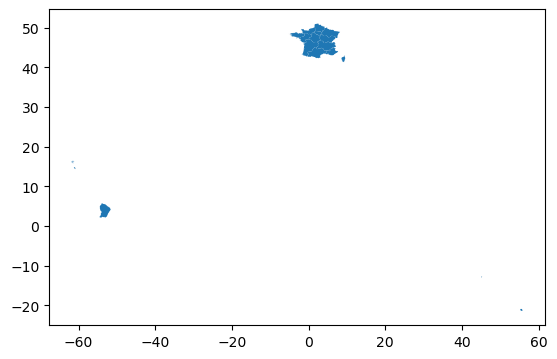

In [9]:
df_reg_avec_om.plot()
plt.show()

In [10]:
## separate regions' geodataframe with metropolitan regions on one side and overseas regions on the other

# sort region code in ascending order
df_reg_avec_om = df_reg_avec_om.sort_values(by="code") 

# for overseas regions (5 regions-departements) keep first 5 lines 
df_rom = df_reg_avec_om[:5] 
df_rom = df_rom.reset_index(drop=True)

# for metropolitan France (13 regions)
df_reg = df_reg_avec_om[5:]  
df_reg = df_reg.reset_index(drop=True)

print(type(df_rom), df_rom.shape)
print(type(df_reg), df_reg.shape)

<class 'geopandas.geodataframe.GeoDataFrame'> (5, 3)
<class 'geopandas.geodataframe.GeoDataFrame'> (13, 3)


In [11]:
# choose 5 anchor points
anchor_pt = pd.DataFrame([[51, -7.223655], [49, -7.223655], [47, -7.223655], [45, -7.223655], [43, -7.223655]], columns=["lat", "lon"])
anchor_pt

lat       lon
0   51 -7.223655
1   49 -7.223655
2   47 -7.223655
3   45 -7.223655
4   43 -7.223655

In [12]:
# find the centroïd of each region's multipolygon 
df_rom["center"] = df_rom['geometry'].centroid  
df_rom

C:\Users\mcampi\AppData\Local\Temp\ipykernel_18100\3708891693.py:2: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




code         nom                                           geometry  \
0   01  Guadeloupe  MULTIPOLYGON (((-61.79038 16.16682, -61.79164 ...   
1   02  Martinique  MULTIPOLYGON (((-60.86733 14.38867, -60.86802 ...   
2   03      Guyane  MULTIPOLYGON (((-53.87049 5.74494, -53.86464 5...   
3   04  La Réunion  MULTIPOLYGON (((55.56891 -21.37670, 55.56843 -...   
4   06     Mayotte  MULTIPOLYGON (((45.04101 -12.64686, 45.04139 -...   

                       center  
0  POINT (-61.53943 16.19773)  
1  POINT (-61.01841 14.65318)  
2   POINT (-53.23535 3.92358)  
3  POINT (55.53254 -21.13326)  
4  POINT (45.14744 -12.82062)

In [13]:
# calculate the distance in latitude and longitude between the centroïd and its corresponding anchor point 

dist_list =[]

for i, row in df_rom.iterrows():
    x_dist = anchor_pt.loc[i, "lon"] - (row["center"].x)  # différence entre longitude
    y_dist = anchor_pt.loc[i, "lat"] - (row["center"].y)  # différence entre latitude
    dist_list.append((x_dist, y_dist))  # ajouter à la liste

dist_list

[(54.31577971685846, 34.80227083315512),
 (53.79475812830232, 34.346815331503464),
 (46.011693861377545, 43.076417030966844),
 (-62.756192214959334, 66.13325609700435),
 (-52.37109553170058, 55.82061630358814)]

In [14]:
# keep each line in different geodataframe
guadeloupe = gpd.GeoDataFrame(df_rom.iloc[0,]).T
martinique = gpd.GeoDataFrame(df_rom.iloc[1,]).T
guyane = gpd.GeoDataFrame(df_rom.iloc[2,]).T
reunion = gpd.GeoDataFrame(df_rom.iloc[3,]).T
mayotte = gpd.GeoDataFrame(df_rom.iloc[4,]).T

In [15]:
# resize Guyane which is bigger than other overseas departments
guyane["geometry"] = guyane["geometry"].scale(0.15,0.15)
guyane

code     nom                                           geometry  \
2   03  Guyane  MULTIPOLYGON (((-53.22434 4.20202, -53.22346 4...   

                                         center  
2  POINT (-53.23534886137755 3.923582969033157)

In [16]:
# shift coordinates of each overseas regions by the distance find earlier
guadeloupe["geometry"] = guadeloupe["geometry"].translate(dist_list[0][0], dist_list[0][1])
martinique["geometry"] = martinique["geometry"].translate(dist_list[1][0], dist_list[1][1])
guyane["geometry"] = guyane["geometry"].translate(dist_list[2][0], dist_list[2][1])
reunion["geometry"] = reunion["geometry"].translate(dist_list[3][0], dist_list[3][1])
mayotte["geometry"] = mayotte["geometry"].translate(dist_list[4][0], dist_list[4][1])

In [17]:
# concatenate new coordinates in a new geodataframe
rom = pd.concat([guadeloupe, martinique, guyane, reunion, mayotte], axis=0)

# resize again the regions 
rom["geometry"] = rom["geometry"].scale(3,3)

In [18]:
# delete "center" columns
del rom["center"]

In [19]:
rom

code         nom                                           geometry
0   01  Guadeloupe  MULTIPOLYGON (((-8.24370 50.95634, -8.24748 50...
1   02  Martinique  MULTIPOLYGON (((-6.76847 48.24538, -6.77054 48...
2   03      Guyane  MULTIPOLYGON (((-7.44070 47.82300, -7.43806 47...
3   04  La Réunion  MULTIPOLYGON (((-7.10267 44.26426, -7.10411 44...
4   06     Mayotte  MULTIPOLYGON (((-7.56639 43.52189, -7.56525 43...

In [20]:
# compare with precedent values
df_rom

code         nom                                           geometry  \
0   01  Guadeloupe  MULTIPOLYGON (((-61.79038 16.16682, -61.79164 ...   
1   02  Martinique  MULTIPOLYGON (((-60.86733 14.38867, -60.86802 ...   
2   03      Guyane  MULTIPOLYGON (((-53.87049 5.74494, -53.86464 5...   
3   04  La Réunion  MULTIPOLYGON (((55.56891 -21.37670, 55.56843 -...   
4   06     Mayotte  MULTIPOLYGON (((45.04101 -12.64686, 45.04139 -...   

                       center  
0  POINT (-61.53943 16.19773)  
1  POINT (-61.01841 14.65318)  
2   POINT (-53.23535 3.92358)  
3  POINT (55.53254 -21.13326)  
4  POINT (45.14744 -12.82062)

In [21]:
# concate metropolitan regions with overseas regions
gdf_reg_avec_om = pd.concat([df_reg, rom], axis=0).reset_index(drop=True)

C:\Users\mcampi\Anaconda3\lib\site-packages\geopandas\array.py:1406: UserWarning:

CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).



In [22]:
gdf_reg_avec_om

code                         nom  \
0    11               Île-de-France   
1    24         Centre-Val de Loire   
2    27     Bourgogne-Franche-Comté   
3    28                   Normandie   
4    32             Hauts-de-France   
5    44                   Grand Est   
6    52            Pays de la Loire   
7    53                    Bretagne   
8    75          Nouvelle-Aquitaine   
9    76                   Occitanie   
10   84        Auvergne-Rhône-Alpes   
11   93  Provence-Alpes-Côte d'Azur   
12   94                       Corse   
13   01                  Guadeloupe   
14   02                  Martinique   
15   03                      Guyane   
16   04                  La Réunion   
17   06                     Mayotte   

                                             geometry  
0   POLYGON ((2.59052 49.07965, 2.59602 49.08171, ...  
1   POLYGON ((2.87463 47.52042, 2.87984 47.51671, ...  
2   POLYGON ((3.62942 46.74946, 3.62655 46.75228, ...  
3   MULTIPOLYGON (((-1.11962 49.35557, -1.11554 49...  
4   POLYGON ((4.14090 49.97876, 4.14407 49.97625, ...  
5   POLYGON ((4.23316 49.95775, 4.23690 49.95858, ...  
6   MULTIPOLYGON (((-2.62284 47.40975, -2.62341 47...  
7   MULTIPOLYGON (((-3.47716 48.88127, -3.47863 48...  
8   MULTIPOLYGON (((1.41519 46.34722, 1.41675 46.3...  
9   MULTIPOLYGON (((1.78613 42.57362, 1.78661 42.5...  
10  POLYGON ((4.78021 46.17668, 4.78024 46.18905, ...  
11  MULTIPOLYGON (((6.94834 44.65482, 6.94769 44.6...  
12  MULTIPOLYGON (((8.58640 41.87389, 8.58667 41.8...  
13  MULTIPOLYGON (((-8.24370 50.95634, -8.24748 50...  
14  MULTIPOLYGON (((-6.76847 48.24538, -6.77054 48...  
15  MULTIPOLYGON (((-7.44070 47.82300, -7.43806 47...  
16  MULTIPOLYGON (((-7.10267 44.26426, -7.10411 44...  
17  MULTIPOLYGON (((-7.56639 43.52189, -7.56525 43...

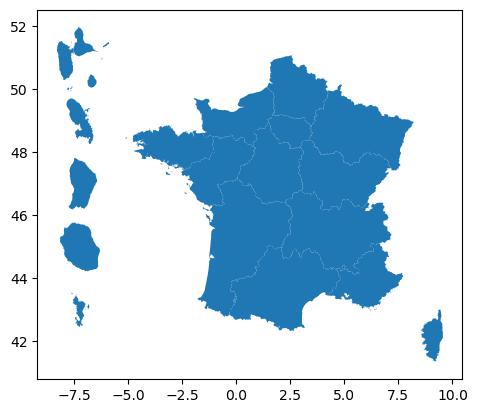

In [23]:
# plot results !
gdf_reg_avec_om.plot()
plt.show()

In [24]:
# change overseas region code by their department code
code_reg_dpt = {"01": "971",
                "02": "972",
                "03": "973",
                "04": "974",
                "06": "976"}

dom = rom.replace({"code": code_reg_dpt})
dom

code         nom                                           geometry
0  971  Guadeloupe  MULTIPOLYGON (((-8.24370 50.95634, -8.24748 50...
1  972  Martinique  MULTIPOLYGON (((-6.76847 48.24538, -6.77054 48...
2  973      Guyane  MULTIPOLYGON (((-7.44070 47.82300, -7.43806 47...
3  974  La Réunion  MULTIPOLYGON (((-7.10267 44.26426, -7.10411 44...
4  976     Mayotte  MULTIPOLYGON (((-7.56639 43.52189, -7.56525 43...

In [25]:
# concatenate metropolitan regions and overseas region 
gdf_dpt_avec_om = pd.concat([df_dpt, dom], axis=0).reset_index(drop=True)

C:\Users\mcampi\Anaconda3\lib\site-packages\geopandas\array.py:1406: UserWarning:

CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).



In [26]:
gdf_dpt_avec_om


code                      nom  \
0     01                      Ain   
1     02                    Aisne   
2     03                   Allier   
3     04  Alpes-de-Haute-Provence   
4     05             Hautes-Alpes   
..   ...                      ...   
96   971               Guadeloupe   
97   972               Martinique   
98   973                   Guyane   
99   974               La Réunion   
100  976                  Mayotte   

                                              geometry  
0    POLYGON ((4.78021 46.17668, 4.78024 46.18905, ...  
1    POLYGON ((3.17296 50.01131, 3.17382 50.01186, ...  
2    POLYGON ((3.03207 46.79491, 3.03424 46.79080, ...  
3    POLYGON ((5.67604 44.19143, 5.67817 44.19051, ...  
4    POLYGON ((6.26057 45.12685, 6.26417 45.12641, ...  
..                                                 ...  
96   MULTIPOLYGON (((-8.24370 50.95634, -8.24748 50...  
97   MULTIPOLYGON (((-6.76847 48.24538, -6.77054 48...  
98   MULTIPOLYGON (((-7.44070 47.82300, -7.43806 47...  
99   MULTIPOLYGON (((-7.10267 44.26426, -7.10411 44...  
100  MULTIPOLYGON (((-7.56639 43.52189, -7.56525 43...  

[101 rows x 3 columns]

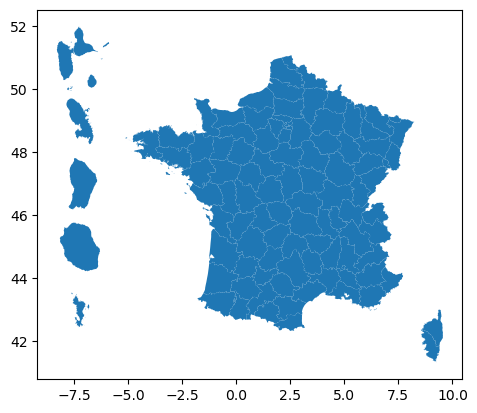

In [27]:
# plot
gdf_dpt_avec_om.plot()
plt.show()

In [ ]:
#########################################################################
#########################################################################
#DO NOT NEED TO RUN THE FOLLOWING CHUNK ANYMORE SINCE YOU ALREADY DID IT#
#########################################################################
#########################################################################

In [136]:
################################################################
#DO NOT NEED TO RUN THIS CHUNK ANYMORE SINCE YOU ALREADY DID IT#
################################################################

# Initialize the Nominatim geocoder
geolocator = Nominatim(user_agent="my_geocoder")


# List of location names
locations = df_code_loc['Location'].unique()

lat_lon_list = []

for location_name in locations:
    try:
        location = geolocator.geocode(location_name)
        if location:
            lat_lon_list.append((location.latitude, location.longitude))
        else:
            print(f"{location_name}: Location not found")
            lat_lon_list.append((None, None))  # Add empty entries
        time.sleep(2)  # Add a 2-second delay between requests
    except Exception as e:
        print(f"Error geocoding {location_name}: {e}")
        lat_lon_list.append((None, None))  # Add empty entries

 NOISY-LE-GRAND BRIAN: Location not found
 MARTIGUES FERRIERE: Location not found
 SAINT- GENIS - POUIL: Location not found
Error geocoding  LA VARENNE BAC: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=+LA+VARENNE+BAC&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
 DRANCY HENRI BARBUSS: Location not found
 VILLEFRANCHE-S/ SAÔN: Location not found
 LE-PONT-DE-BEAUVOISI: Location not found
 TOULORGE-JUTEAU CHER: Location not found
 TOULORGE-JUTEAU VALO: Location not found
 NANTES SAINTE-THERES: Location not found
 MARSEILLE SAINTE-ANN: Location not found
 AIX ALL. PROVENCALES: Location not found
Error geocoding  LE HAVRE HOTEL DE VI: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=+LE+HAVRE+HOTEL+DE+VI&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnecti

In [ ]:
##########################################################################
#DO NOT NEED TO RUN THE FOLLOWING CHUNKs ANYMORE SINCE YOU ALREADY DID IT#
##########################################################################

In [137]:
len(lat_lon_list)

742

In [138]:
len(locations)

742

In [139]:
len(locations) - len(lat_lon_list)

0

In [140]:
np.shape(lat_lon_list)

(742, 2)

In [141]:
[i for i, (lat, lon) in enumerate(lat_lon_list) if lat is None and lon is None]

[6,
 24,
 26,
 40,
 45,
 49,
 58,
 113,
 114,
 194,
 206,
 207,
 209,
 241,
 325,
 339,
 370,
 379,
 384,
 389,
 400,
 401,
 410,
 421,
 422,
 424,
 432,
 442,
 446,
 448,
 476,
 521,
 539,
 566,
 570,
 591,
 593,
 595,
 602,
 619,
 624,
 640,
 669,
 682,
 683,
 695,
 707,
 708,
 709,
 724,
 725,
 729,
 730]

In [161]:
df_code_loc['Longitude'] = [lon for _, lon in lat_lon_list]
df_code_loc['Latitude'] = [lat for lat, _ in lat_lon_list]
df_code_loc['geometry'] =  [Point(lon, lat) for lat, lon in zip(df_code_loc['Latitude'], df_code_loc['Longitude'])]

In [ ]:
#######################
#RUN THIS ONE TO CHECK#
#######################

In [100]:
df_code_loc

Centre               Description Centre                 Location  \
0         2            AMPLIFON PARIS WAGRAM             PARIS WAGRAM   
1         3            AMPLIFON PARIS NATION             PARIS NATION   
2         4            AMPLIFON PARIS ALESIA             PARIS ALESIA   
3         5          AMPLIFON COMBS-LA-VILLE           COMBS-LA-VILLE   
4         6    AMPLIFON BOULOGNE-BILLANCOURT     BOULOGNE-BILLANCOURT   
..      ...                              ...                      ...   
737     989             AMPLIFON Wambrechies              Wambrechies   
738     992                  AMPLIFON ENGLOS                   ENGLOS   
739     993  AMPLIFON St Gilles Croix de Vie   St Gilles Croix de Vie   
740     998                     AMPLIFON.COM                     .COM   
741       1          AMPLIFON ST QUAY PERROS           ST QUAY PERROS   

     Longitude   Latitude                       geometry  
0     2.303719  48.884005    POINT (2.3037188 48.884005)  
1     2.395567  48.847611    POINT (2.3955668 48.847611)  
2     2.326832  48.827912   POINT (2.3268316 48.8279122)  
3     2.564877  48.664699    POINT (2.564877 48.6646994)  
4     2.240206  48.835665    POINT (2.240206 48.8356649)  
..         ...        ...                            ...  
737   3.052181  50.686194   POINT (3.0521806 50.6861944)  
738   2.956373  50.626389   POINT (2.9563734 50.6263892)  
739  -1.925455  46.692985   POINT (-1.9254545 46.692985)  
740  36.299325  36.037594  POINT (36.2993249 36.0375943)  
741  -3.447039  48.792334  POINT (-3.4470386 48.7923337)  

[742 rows x 6 columns]

In [163]:
# SAVE IT SO NO NEED TO REDO THE MATCHING OF LON LAT
#df_code_loc.to_excel('my_amplifon_centers.xlsx', index=False)

In [101]:
geo_loc= df_code_loc.iloc[:, [3, 4]]
geo_loc = gpd.GeoDataFrame(geo_loc)
geometry = [Point(lon, lat) for lon, lat in zip(geo_loc['Longitude'], geo_loc['Latitude'])]
geo_loc = gpd.GeoDataFrame(geo_loc, geometry=geometry)

In [102]:
df_code_loc['Department'] = gpd.sjoin(geo_loc, gdf_dpt_avec_om,  how='left', op='within').iloc[:, [5]]

C:\Users\mcampi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.

C:\Users\mcampi\AppData\Local\Temp\ipykernel_18100\2575851386.py:1: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326




In [103]:
len(df_code_loc['Department'].unique()) #maybe it s better per region

94

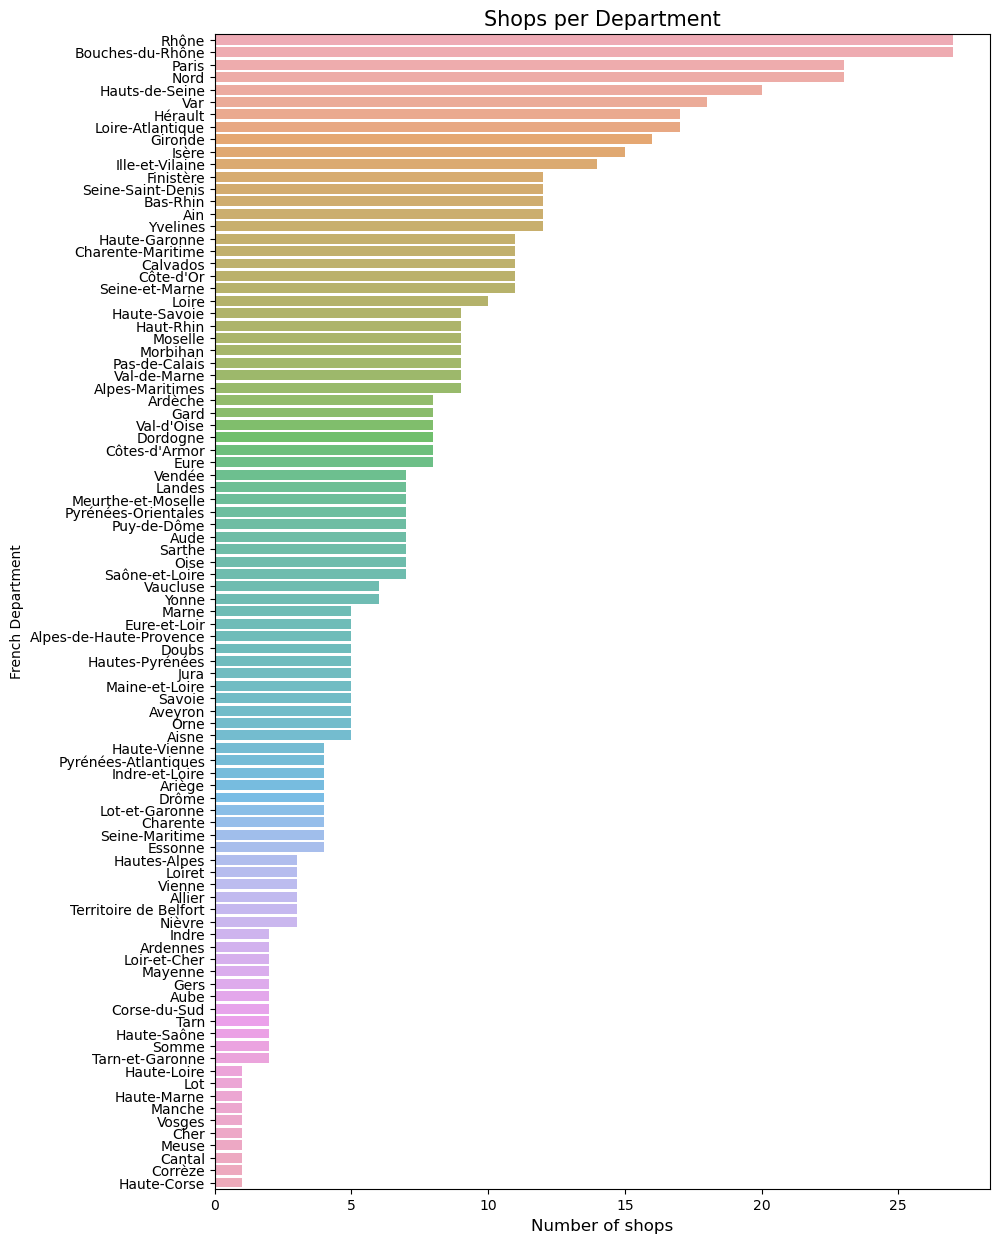

In [104]:
shop_per_dep = df_code_loc['Department'].value_counts()
plt.figure(figsize=(10,15))
sn.barplot(y=shop_per_dep.index, x=shop_per_dep.values, alpha=0.8)
plt.xlabel('Number of shops', fontsize=12)
plt.ylabel('French Department', fontsize=10)
plt.title("Shops per Department", fontsize=15)
plt.show()

In [105]:
shop_counts_df = df_code_loc['Department'].value_counts().reset_index()
shop_counts_df.columns = ['nom', 'Count']

In [106]:
map_france_shop = gdf_dpt_avec_om

In [107]:
map_france_shop

code                      nom  \
0     01                      Ain   
1     02                    Aisne   
2     03                   Allier   
3     04  Alpes-de-Haute-Provence   
4     05             Hautes-Alpes   
..   ...                      ...   
96   971               Guadeloupe   
97   972               Martinique   
98   973                   Guyane   
99   974               La Réunion   
100  976                  Mayotte   

                                              geometry  
0    POLYGON ((4.78021 46.17668, 4.78024 46.18905, ...  
1    POLYGON ((3.17296 50.01131, 3.17382 50.01186, ...  
2    POLYGON ((3.03207 46.79491, 3.03424 46.79080, ...  
3    POLYGON ((5.67604 44.19143, 5.67817 44.19051, ...  
4    POLYGON ((6.26057 45.12685, 6.26417 45.12641, ...  
..                                                 ...  
96   MULTIPOLYGON (((-8.24370 50.95634, -8.24748 50...  
97   MULTIPOLYGON (((-6.76847 48.24538, -6.77054 48...  
98   MULTIPOLYGON (((-7.44070 47.82300, -7.43806 47...  
99   MULTIPOLYGON (((-7.10267 44.26426, -7.10411 44...  
100  MULTIPOLYGON (((-7.56639 43.52189, -7.56525 43...  

[101 rows x 3 columns]

In [108]:
map_france_shop = map_france_shop.merge(shop_counts_df, on='nom', how='inner')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


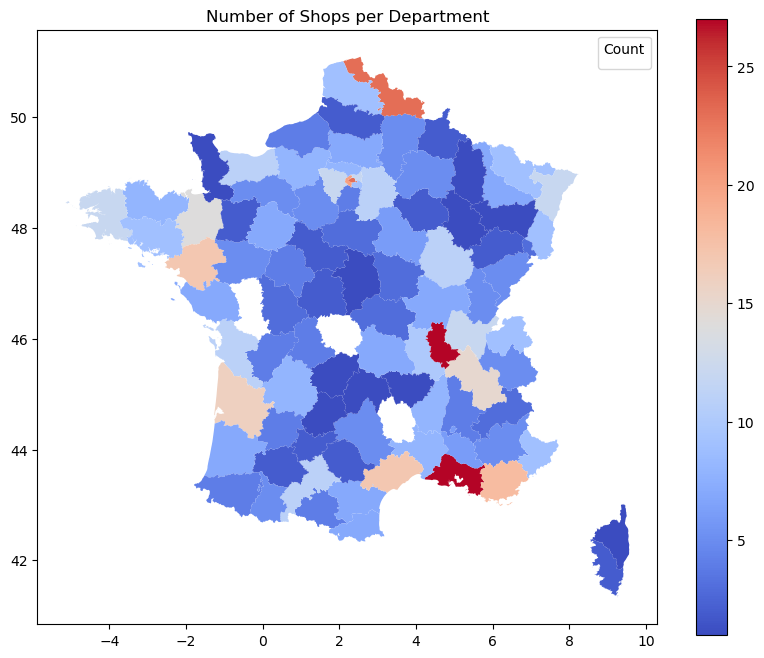

In [109]:
# Plot the GeoDataFrame with color based on the count
ax = map_france_shop.plot(column='Count', legend=True, figsize=(10, 8), cmap='coolwarm') #viridis plasma coolwarm cividis rainbow inferno

# Add a title and adjust legend settings if needed
ax.set_title('Number of Shops per Department')
ax.legend(title='Count')

plt.show()

# COSI DATA

In [63]:
#ANONYM DATA
df = df.drop(df.columns[[1, 2]], axis=1)

In [68]:
quest_cosi_n = df['QUESTION_COSI'].value_counts()

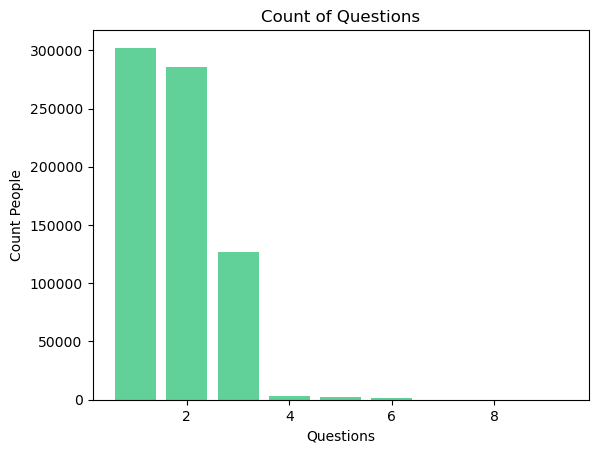

In [69]:
plt.bar(quest_cosi_n.index, quest_cosi_n.values, color="#61d199")
plt.xlabel('Questions')
plt.ylabel('Count People')
plt.title('Count of Questions')
plt.show()

## Question 1

In [70]:
df_q1 = df[df['QUESTION_COSI'] == 1]

### CHECK MISSING DATA (here since the data base is smaller)

<Axes: >

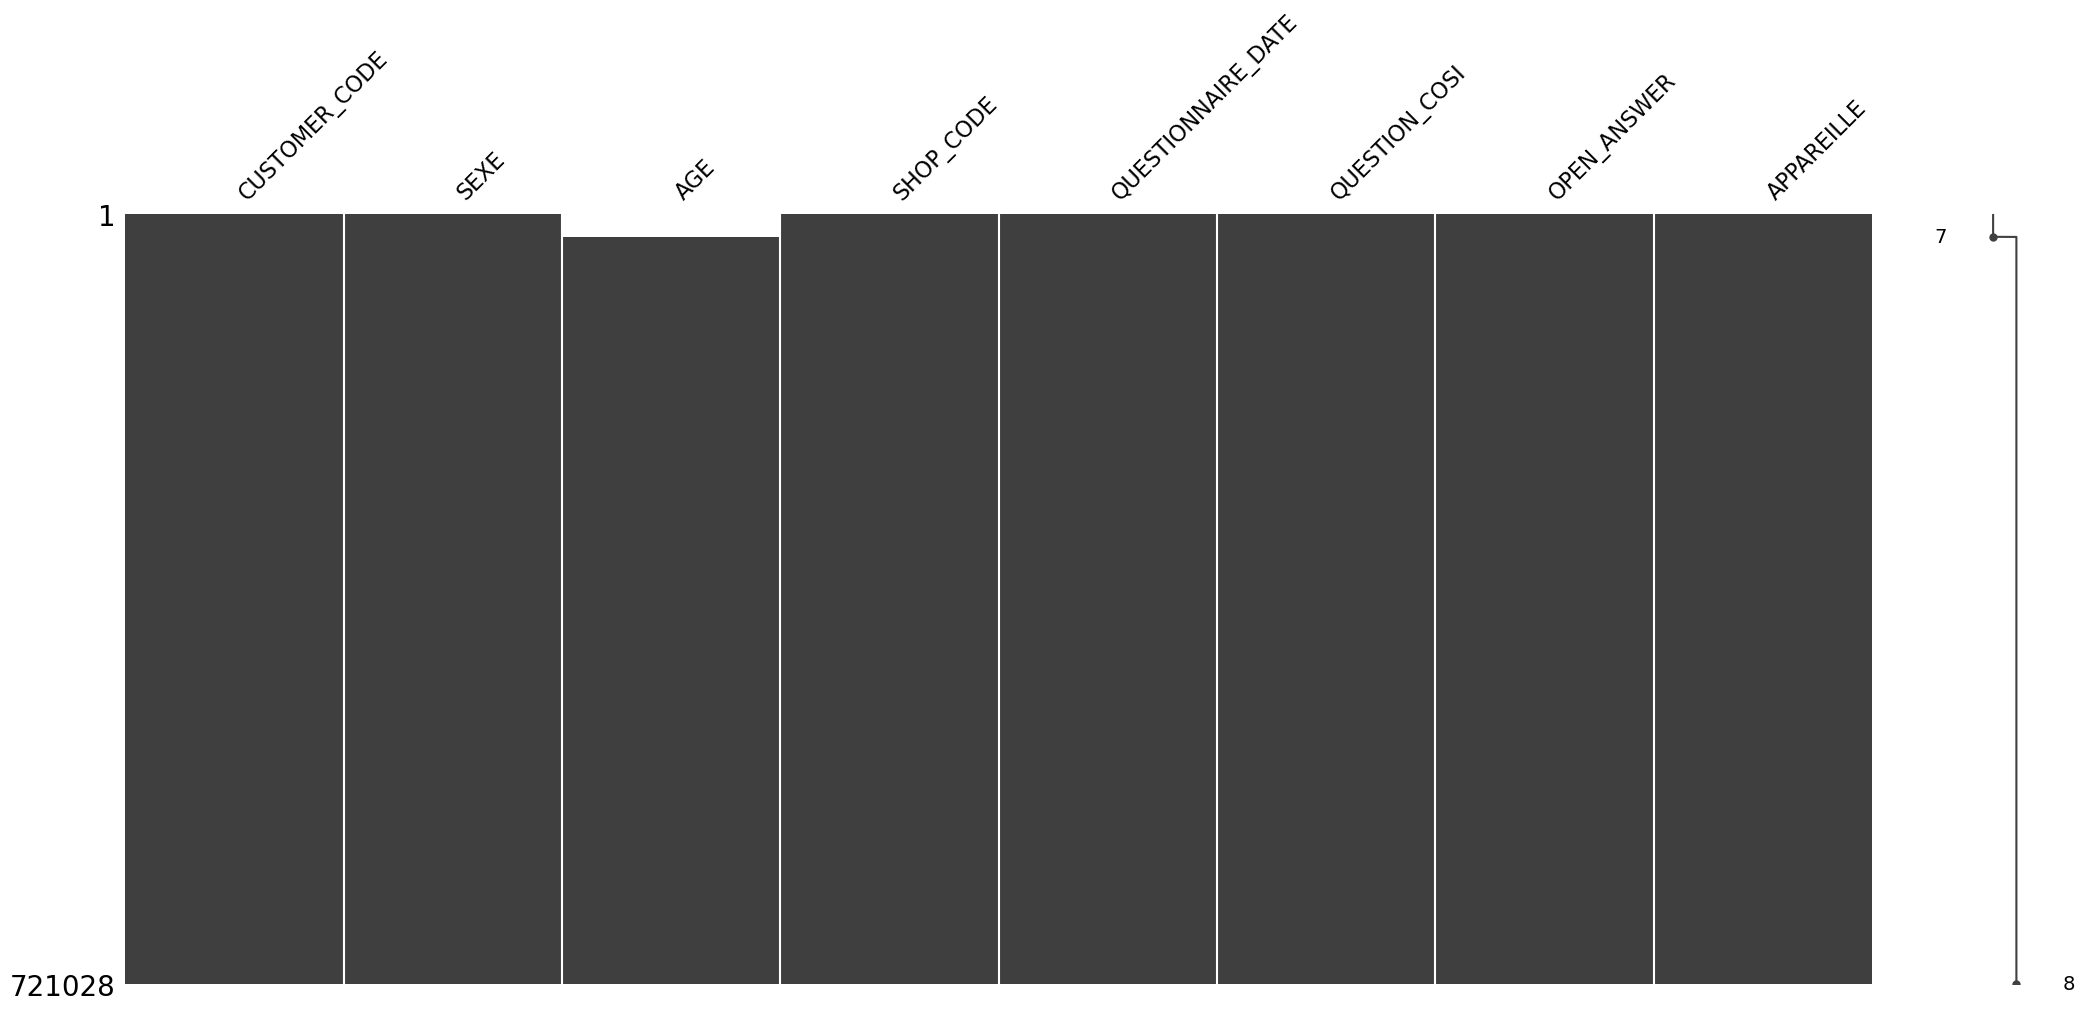

In [72]:
msno.matrix(df)

In [74]:
missing_percent_q1 = df_q1.isna().mean() * 100  # Returns a Series with percentages of missing values
missing_percent_q1

CUSTOMER_CODE         0.000000
SEXE                  0.000000
AGE                   3.250784
SHOP_CODE             0.000000
QUESTIONNAIRE_DATE    0.000000
QUESTION_COSI         0.000000
OPEN_ANSWER           0.000000
APPAREILLE            0.000000
dtype: float64

### Plots to analyse the data

In [75]:
df_q1_counts = df_q1.groupby(['SEXE', 'APPAREILLE']).size().reset_index(name='Count')

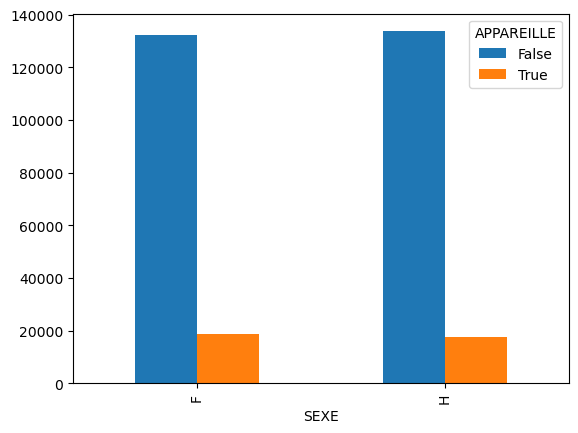

In [76]:
pivot_dfq1_counts = df_q1_counts.pivot(index='SEXE', columns='APPAREILLE', values='Count')
pivot_dfq1_counts.plot(kind='bar', stacked=False)
plt.show()

In [77]:
df_q1

CUSTOMER_CODE SEXE    AGE  SHOP_CODE QUESTIONNAIRE_DATE  QUESTION_COSI  \
0           00000189    H    NaN        725         2020-05-14              1   
3           00000204    F    NaN        371         2020-06-24              1   
4           00000329    F    NaN        708         2021-10-22              1   
9           00000330    H    NaN        458         2020-05-25              1   
11          00000384    H    NaN        261         2020-06-03              1   
...              ...  ...    ...        ...                ...            ...   
721020      DUMFR547    H  123.0        547         2022-09-07              1   
721022      DUMFR548    H  123.0        547         2022-09-07              1   
721024      DUMFR570    H  123.0        570         2022-07-07              1   
721026      06007393    H  222.0         60         2022-02-24              1   
721027      81880800    H  143.0        818         2021-01-13              1   

                                              OPEN_ANSWER  APPAREILLE  
0       S'équiper de nouveau après la perte de mon anc...       False  
3       je souhaite faire un bilan auditif suite à vot...       False  
4                          mieux comprendre dans le bruit       False  
9                         J'ai des acouphènes invalidants       False  
11                  moins faire repeter femme et enfants        False  
...                                                   ...         ...  
721020        j'aimerais mieux comprendre les voix douces       False  
721022          j'aimerais mieux comprendre dans le bruit       False  
721024                    Faire le point sur mon audition       False  
721026          j'aimerai connaitre mon niveau d'audition       False  
721027                                          entendre        False  

[302204 rows x 8 columns]

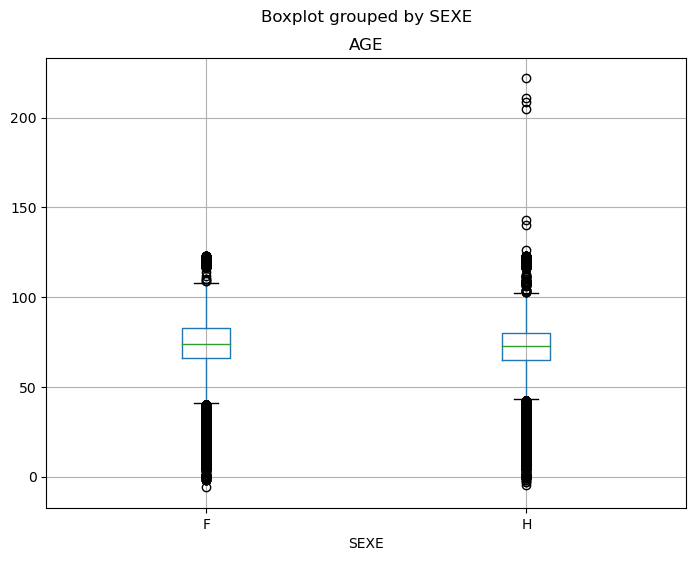

In [78]:
df_q1.boxplot(column='AGE', by='SEXE', figsize=(8, 6))
plt.show()

In [79]:
df_q1_age_count = df_q1['AGE'].value_counts()
trace =go.Bar(
    x=df_q1_age_count.index,
    y=df_q1_age_count.values,
    marker=dict(
        #color = np.random.randn(500), #set color equal to a variable
        color = df_q1_age_count.values,
        #colorscale='Viridis',
        showscale=True
    ),
)
layout = go.Layout(
    title='Age distribution'
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="age")

In [80]:
df_q1_sexage_count = df_q1.groupby(['SEXE', 'AGE']).size().reset_index(name='Count')

# Create bar plots for each SEX category
traces = []
for sex_value in df_q1_sexage_count['SEXE'].unique():
    subset = df_q1_sexage_count[df_q1_sexage_count['SEXE'] == sex_value]
    trace = go.Bar(
        x=subset['AGE'],
        y=subset['Count'],
        name=f'SEX {sex_value}',
        marker=dict(
            color=subset['Count'],
           # colorscale='Viridis',  # Choose a color scale
            showscale=True
        ),
    )
    traces.append(trace)

layout = go.Layout(
    title='Age Distribution by SEX',
    xaxis=dict(title='Age'),
    yaxis=dict(title='Count'),
    barmode='group',  # To show grouped bar plots
)

layout = go.Layout(
        title=f'Age Distribution for SEX',
        xaxis=dict(title='Age'),
        yaxis=dict(title='Count'),
    )
    

fig = go.Figure(data=traces, layout=layout)
py.iplot(fig, filename="age_distribution_by_sex")

### Spatial Distributions Plots

In [110]:
df_code_loc.rename(columns={'Centre': 'SHOP_CODE'}, inplace=True)

In [116]:
df_q1_dp = df_q1.merge(df_code_loc[['SHOP_CODE', 'Department']], on='SHOP_CODE', how='left')

In [117]:
df_q1_dp

CUSTOMER_CODE SEXE    AGE  SHOP_CODE QUESTIONNAIRE_DATE  QUESTION_COSI  \
0           00000189    H    NaN        725         2020-05-14              1   
1           00000204    F    NaN        371         2020-06-24              1   
2           00000329    F    NaN        708         2021-10-22              1   
3           00000330    H    NaN        458         2020-05-25              1   
4           00000384    H    NaN        261         2020-06-03              1   
...              ...  ...    ...        ...                ...            ...   
302199      DUMFR547    H  123.0        547         2022-09-07              1   
302200      DUMFR548    H  123.0        547         2022-09-07              1   
302201      DUMFR570    H  123.0        570         2022-07-07              1   
302202      06007393    H  222.0         60         2022-02-24              1   
302203      81880800    H  143.0        818         2021-01-13              1   

                                              OPEN_ANSWER  APPAREILLE  \
0       S'équiper de nouveau après la perte de mon anc...       False   
1       je souhaite faire un bilan auditif suite à vot...       False   
2                          mieux comprendre dans le bruit       False   
3                         J'ai des acouphènes invalidants       False   
4                   moins faire repeter femme et enfants        False   
...                                                   ...         ...   
302199        j'aimerais mieux comprendre les voix douces       False   
302200          j'aimerais mieux comprendre dans le bruit       False   
302201                    Faire le point sur mon audition       False   
302202          j'aimerai connaitre mon niveau d'audition       False   
302203                                          entendre        False   

            Department  
0       Maine-et-Loire  
1              Moselle  
2               Manche  
3               Savoie  
4       Seine-et-Marne  
...                ...  
302199             NaN  
302200             NaN  
302201             NaN  
302202             NaN  
302203        Yvelines  

[302204 rows x 9 columns]

In [119]:
pp_counts_df_q1 = df_q1_dp['Department'].value_counts().reset_index()
pp_counts_df_q1.columns = ['nom', 'Count']

In [120]:
map_france_ppq1 = gdf_dpt_avec_om
map_france_ppq1 = map_france_ppq1.merge(pp_counts_df_q1, on='nom', how='inner')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


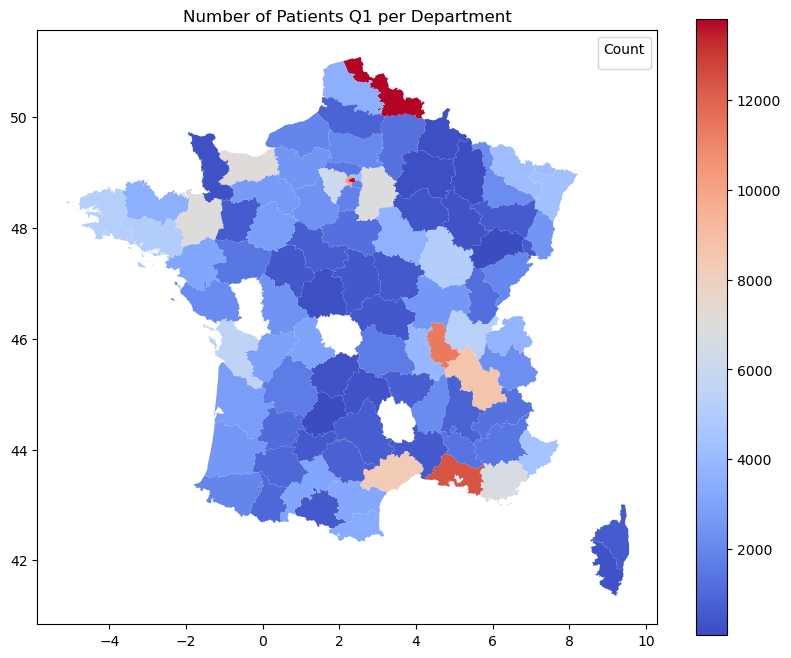

In [122]:
# Plot the GeoDataFrame with color based on the count
ax = map_france_ppq1.plot(column='Count', legend=True, figsize=(10, 8), cmap='coolwarm') #viridis plasma coolwarm cividis rainbow inferno

# Add a title and adjust legend settings if needed
ax.set_title('Number of Patients Q1 per Department')
ax.legend(title='Count')

plt.show()

In [125]:
df_q1_dp.groupby(['Department', 'SEXE']).size().reset_index(name='count')

Department SEXE  count
0          Ain    F   2571
1          Ain    H   2687
2        Aisne    F    534
3        Aisne    H    736
4       Allier    F    244
..         ...  ...    ...
181     Vosges    H    308
182      Yonne    F   1778
183      Yonne    H   1856
184   Yvelines    F   3193
185   Yvelines    H   2967

[186 rows x 3 columns]

In [196]:
df_q1_dp = df_q1_dp.fillna('NaN')

In [198]:
df_q1_dp

CUSTOMER_CODE SEXE    AGE  SHOP_CODE QUESTIONNAIRE_DATE  QUESTION_COSI  \
0           00000189    H     NA        725         2020-05-14              1   
1           00000204    F     NA        371         2020-06-24              1   
2           00000329    F     NA        708         2021-10-22              1   
3           00000330    H     NA        458         2020-05-25              1   
4           00000384    H     NA        261         2020-06-03              1   
...              ...  ...    ...        ...                ...            ...   
302199      DUMFR547    H  123.0        547         2022-09-07              1   
302200      DUMFR548    H  123.0        547         2022-09-07              1   
302201      DUMFR570    H  123.0        570         2022-07-07              1   
302202      06007393    H  222.0         60         2022-02-24              1   
302203      81880800    H  143.0        818         2021-01-13              1   

                                              OPEN_ANSWER  APPAREILLE  \
0       S'équiper de nouveau après la perte de mon anc...       False   
1       je souhaite faire un bilan auditif suite à vot...       False   
2                          mieux comprendre dans le bruit       False   
3                         J'ai des acouphènes invalidants       False   
4                   moins faire repeter femme et enfants        False   
...                                                   ...         ...   
302199        j'aimerais mieux comprendre les voix douces       False   
302200          j'aimerais mieux comprendre dans le bruit       False   
302201                    Faire le point sur mon audition       False   
302202          j'aimerai connaitre mon niveau d'audition       False   
302203                                          entendre        False   

            Department  
0       Maine-et-Loire  
1              Moselle  
2               Manche  
3               Savoie  
4       Seine-et-Marne  
...                ...  
302199              NA  
302200              NA  
302201              NA  
302202              NA  
302203        Yvelines  

[302204 rows x 9 columns]

In [199]:
q1_grouped_sexdp = df_q1_dp.groupby(['SEXE'])
unique_groups = list(q1_grouped_sexdp.groups.keys())
split_q1_sexdp = [q1_grouped_sexdp.get_group(group) for group in unique_groups]


In [200]:
pp_counts_df_q1_f = split_q1_sexdp[0]['Department'].value_counts().reset_index()
pp_counts_df_q1_f.columns = ['nom', 'Count']

pp_counts_df_q1_m = split_q1_sexdp[1]['Department'].value_counts().reset_index()
pp_counts_df_q1_m.columns = ['nom', 'Count']

In [201]:
map_france_ppq1_f = gdf_dpt_avec_om
map_france_ppq1_f = map_france_ppq1_f.merge(pp_counts_df_q1_f, on='nom', how='inner')

map_france_ppq1_m = gdf_dpt_avec_om
map_france_ppq1_m = map_france_ppq1_m.merge(pp_counts_df_q1_m, on='nom', how='inner')

In [202]:
# Define custom segmented color maps for male (blue shades) and female (pink shades)
cmap_male = LinearSegmentedColormap.from_list('cmap_male', ['#B2DDFF', '#0072B2'])
cmap_female = LinearSegmentedColormap.from_list('cmap_female', ['#FFB2C8', '#E30066'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


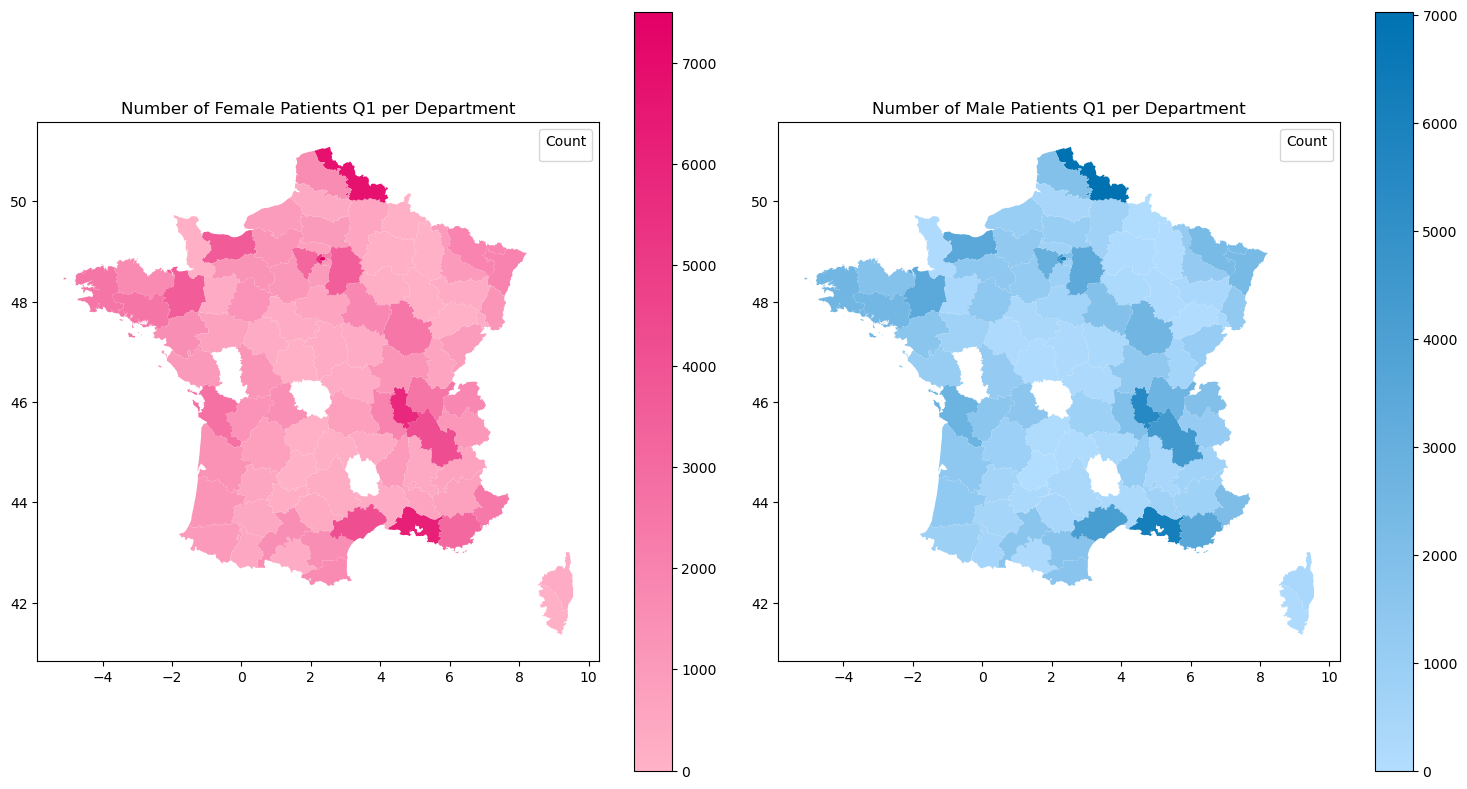

In [203]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

# Plot the GeoDataFrame with color based on the count in the first subplot
map_france_ppq1_f.plot(column='Count', legend=True, ax=axs[0], cmap=cmap_female, vmin=0, vmax=np.max(map_france_ppq1_f["Count"]))
axs[0].set_title('Number of Female Patients Q1 per Department')
axs[0].legend(title='Count')

# Plot the GeoDataFrame with color based on the count in the second subplot
map_france_ppq1_m.plot(column='Count', legend=True, ax=axs[1], cmap=cmap_male, vmin=0, vmax=np.max(map_france_ppq1_m["Count"]))
axs[1].set_title('Number of Male Patients Q1 per Department')
axs[1].legend(title='Count')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [218]:
df_q1_dp_filt = df_q1_dp[df_q1_dp['Department'] != 'NA']
df_q1_dp_filt = df_q1_dp[df_q1_dp['AGE'] != 'NA']

# Calculate the average age within each Department
q1_average_age_dp = df_q1_dp_filt.groupby('Department')['AGE'].mean().reset_index()
q1_average_age_dp.columns = ['nom', 'Average Age']

In [223]:
map_france_av_age_q1 = gdf_dpt_avec_om
map_france_av_age_q1 = map_france_av_age_q1.merge(q1_average_age_dp, on='nom', how='inner')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


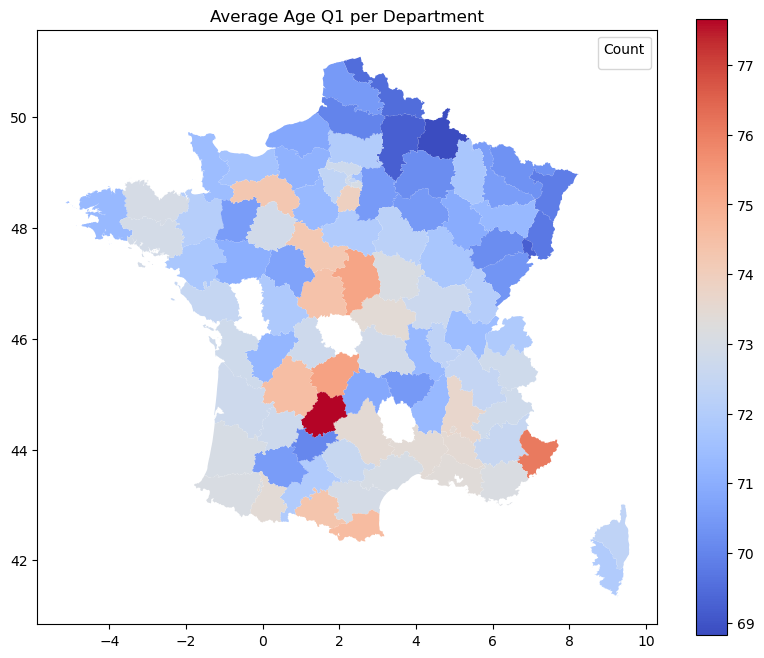

In [226]:
# Plot the GeoDataFrame with color based on the count
ax = map_france_av_age_q1.plot(column='Average Age', legend=True, figsize=(10, 8), cmap='coolwarm') #viridis plasma coolwarm cividis rainbow inferno

# Add a title and adjust legend settings if needed
ax.set_title('Average Age Q1 per Department')
ax.legend(title='Count')

plt.show()

In [236]:
q1_grouped_appdp = df_q1_dp.groupby(['APPAREILLE'])
unique_groups = list(q1_grouped_appdp.groups.keys())
split_q1_appdp = [q1_grouped_appdp.get_group(group) for group in unique_groups]


pp_countsapp_df_q1_f = split_q1_appdp[0]['Department'].value_counts().reset_index()
pp_countsapp_df_q1_f.columns = ['nom', 'Count']

pp_countsapp_df_q1_m = split_q1_appdp[1]['Department'].value_counts().reset_index()
pp_countsapp_df_q1_m.columns = ['nom', 'Count']

In [240]:
map_france_ppappq1_f = gdf_dpt_avec_om
map_france_ppappq1_f = map_france_ppappq1_f.merge(pp_countsapp_df_q1_f, on='nom', how='inner')

map_france_ppappq1_m = gdf_dpt_avec_om
map_france_ppappq1_m = map_france_ppappq1_m.merge(pp_countsapp_df_q1_m, on='nom', how='inner')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


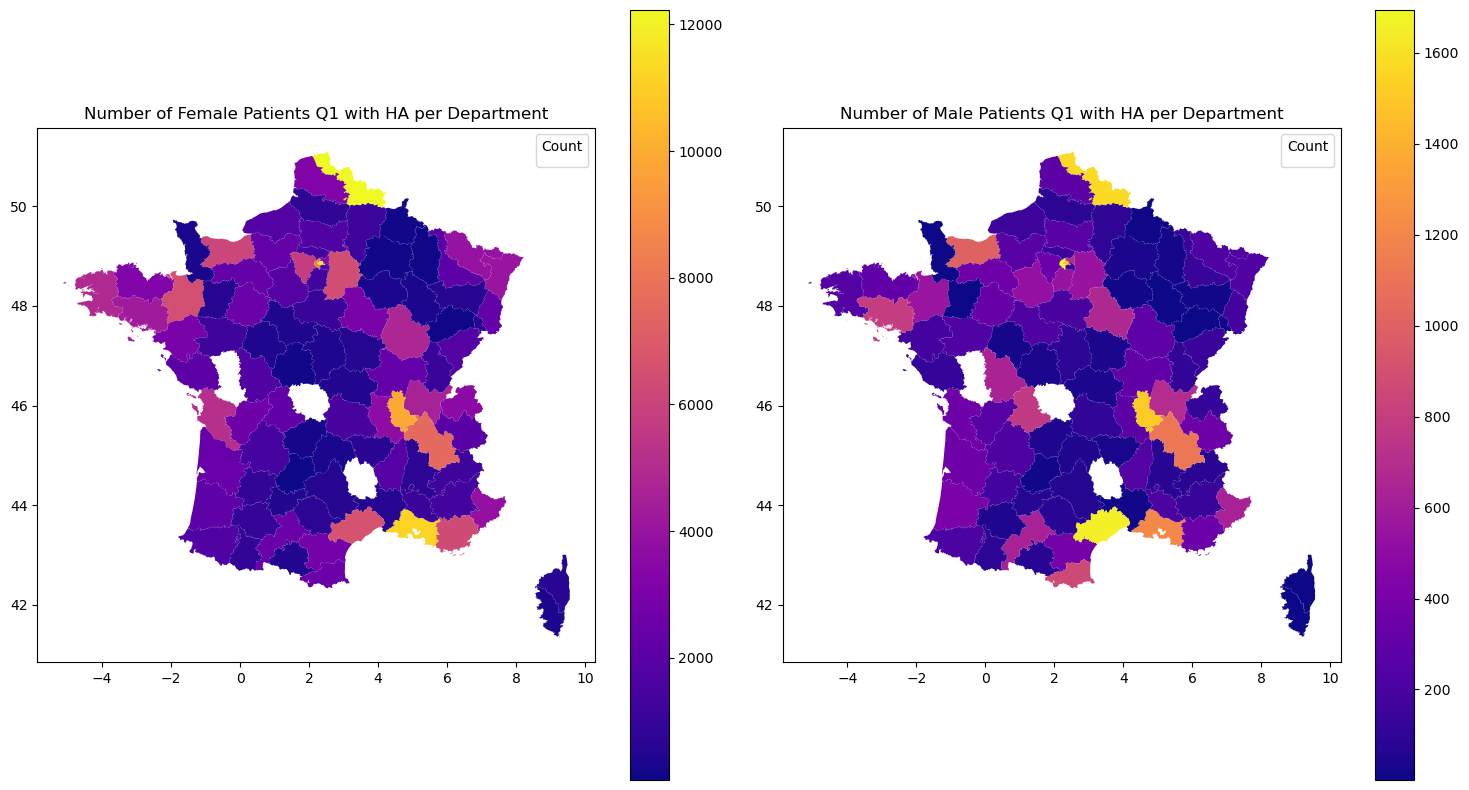

In [243]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

# Plot the GeoDataFrame with color based on the count in the first subplot
map_france_ppappq1_f.plot(column='Count', legend=True, ax=axs[0], cmap= 'plasma')
axs[0].set_title('Number of Female Patients Q1 with HA per Department')
axs[0].legend(title='Count')

# Plot the GeoDataFrame with color based on the count in the second subplot
map_france_ppappq1_m.plot(column='Count', legend=True, ax=axs[1], cmap='plasma')
axs[1].set_title('Number of Male Patients Q1 with HA per Department')
axs[1].legend(title='Count')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

### MERGE ANSWERS by CATEGORIES + SUMMARY + STOPWORD (divide this when you start to do it on the entire data)

In [ ]:
#############################
#MERGE ANSWERS by CATEGORIES# --> TODO: decide categories
#############################

# F vs H within each department

In [252]:
q1_ans_f_dp = split_q1_sexdp[0].groupby('Department')['OPEN_ANSWER'].apply(lambda x: '. '.join(x)).reset_index(name='MergedAnswers')
q1_ans_m_dp = split_q1_sexdp[1].groupby('Department')['OPEN_ANSWER'].apply(lambda x: '. '.join(x)).reset_index(name='MergedAnswers')

In [ ]:
###############################
#SUMMARY of THE DATA with BERT#
###############################

In [257]:
# Initialize the summarizer
bert_model = Summarizer()

C:\Users\mcampi\Anaconda3\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning:

`huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mcampi\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development



In [288]:
# Download the list of French stop words from NLTK
nltk.download('stopwords')
stop_words = set(stopwords.words("french"))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mcampi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [272]:
prova = q1_ans_f_dp.head(2)

In [302]:
provam = q1_ans_m_dp.head(2)

In [273]:
prova

Department                                      MergedAnswers
0        Ain  je souhaite faire un bilan de mon audition car...
1      Aisne  realiser un bilan gratuit.. réaliser un bilan ...

In [280]:
prova['Summary'] = prova['MergedAnswers'].apply(lambda response: bert_model(response, ratio=0.0))

C:\Users\mcampi\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\mcampi\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

C:\Users\mcampi\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\mcampi\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Use

In [303]:
provam['Summary'] = provam['MergedAnswers'].apply(lambda response: bert_model(response, ratio=0.0))

C:\Users\mcampi\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\mcampi\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.

C:\Users\mcampi\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\mcampi\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Use

In [289]:
prova

Department                                      MergedAnswers  \
0        Ain  je souhaite faire un bilan de mon audition car...   
1      Aisne  realiser un bilan gratuit.. réaliser un bilan ...   

                                             Summary  
0  je souhaite faire un bilan de mon audition car...  
1  realiser un bilan gratuit.. réaliser un bilan ...

In [304]:
provam

Department                                      MergedAnswers  \
0        Ain  baisser le son de la tv . baisser le son de la...   
1      Aisne  mieux comprendre. essayer d'atténuer les acoup...   

                                             Summary  
0  Je souhaite un appareil pris en charge à 100%....  
1  Mieux comprendre en réunion bruyante.. Mieux e...

In [284]:
prova['Summary'][1]

'realiser un bilan gratuit.. réaliser un bilan auditif. mieux comprendre en situation sonores bruyantes.. mieux comprendre les films à la télévision.. Mieux comprendre dans les differentes situations du quotidiens._x000D_\n.'

In [290]:
# Define a function to clean summaries by removing stop words
def clean_summary(summary):
    words = summary.split()
    cleaned_words = [word for word in words if word.lower() not in stop_words]
    cleaned_summary = ' '.join(cleaned_words)
    return cleaned_summary

In [291]:
# Apply the cleaning function to the 'Summary' column and create 'CleanedSummary' column
prova['CleanedSummary'] = prova['Summary'].apply(clean_summary)

C:\Users\mcampi\AppData\Local\Temp\ipykernel_18100\1005746552.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [305]:
# Apply the cleaning function to the 'Summary' column and create 'CleanedSummary' column
provam['CleanedSummary'] = provam['Summary'].apply(clean_summary)

C:\Users\mcampi\AppData\Local\Temp\ipykernel_18100\3349403060.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [296]:
prova['CleanedSummary'][0]

'souhaite faire bilan audition car dit sourde. Madame souhaite avoir infos appareils non rechargeables.'

In [306]:
provam['CleanedSummary'][0]

"souhaite appareil pris charge 100%. Monsieur souhaite faire essai d'appareils non rechargeables."

In [307]:
# Combine all cleaned summaries into a single string
all_summaries_q1_f = ' '.join(prova['CleanedSummary'])
all_summaries_q1_m = ' '.join(provam['CleanedSummary'])

In [308]:
# Create a WordCloud object
wc_q1_f = WordCloud(width=800, height=400, background_color='white').generate(all_summaries_q1_f)
wc_q1_m = WordCloud(width=800, height=400, background_color='white').generate(all_summaries_q1_m)

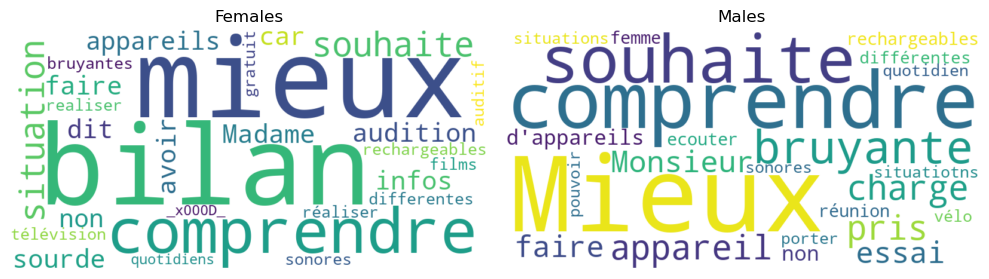

In [311]:
# Create a figure with two subplots for the word clouds
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(wc_q1_f, interpolation='bilinear')
plt.title('Females')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wc_q1_m, interpolation='bilinear')
plt.title('Males')
plt.axis('off')

plt.tight_layout()
plt.show()

In [322]:
# Create a WordCloud object
wc_q1_f_dp = [WordCloud(width=800, height=400, background_color='white').generate(prova['CleanedSummary'][i]) for i in range(0,len(prova))]
wc_q1_m_dp =[WordCloud(width=800, height=400, background_color='white').generate(provam['CleanedSummary'][i]) for i in range(0,len(provam))]

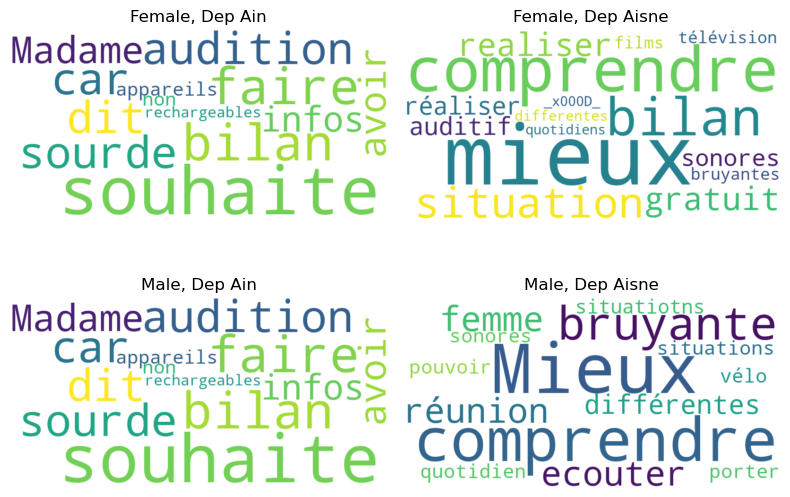

In [326]:
# Create a 2x2 subplot grid for the word clouds
plt.figure(figsize=(8, 6))

plt.subplot(2, 2, 1)
plt.imshow(wc_q1_f_dp[0], interpolation='bilinear')
plt.title('Female, Dep Ain')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(wc_q1_f_dp[1], interpolation='bilinear')
plt.title('Female, Dep Aisne')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(wc_q1_f_dp[0], interpolation='bilinear')
plt.title('Male, Dep Ain')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(wc_q1_m_dp[1], interpolation='bilinear')
plt.title('Male, Dep Aisne')
plt.axis('off')

plt.tight_layout()
plt.show()

In [325]:
prova

Department                                      MergedAnswers  \
0        Ain  je souhaite faire un bilan de mon audition car...   
1      Aisne  realiser un bilan gratuit.. réaliser un bilan ...   

                                             Summary  \
0  je souhaite faire un bilan de mon audition car...   
1  realiser un bilan gratuit.. réaliser un bilan ...   

                                      CleanedSummary  
0  souhaite faire bilan audition car dit sourde. ...  
1  realiser bilan gratuit.. réaliser bilan auditi...

In [328]:
df_q1_dp["OPEN_ANSWER"]

0         S'équiper de nouveau après la perte de mon anc...
1         je souhaite faire un bilan auditif suite à vot...
2                            mieux comprendre dans le bruit
3                           J'ai des acouphènes invalidants
4                     moins faire repeter femme et enfants 
                                ...                        
302199          j'aimerais mieux comprendre les voix douces
302200            j'aimerais mieux comprendre dans le bruit
302201                      Faire le point sur mon audition
302202            j'aimerai connaitre mon niveau d'audition
302203                                            entendre 
Name: OPEN_ANSWER, Length: 302204, dtype: object